In [2]:
import pandas as pd
import numpy as np
import itertools as it
import os
import io
import logging

import boto3
import sys
import json
import snowflake.connector

# Reading Data 

In [3]:
from abc import ABCMeta, abstractmethod

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
    

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [5]:
## WRITE OR READ FROM S3 ####
import boto3
import io

s3 = boto3.resource('s3')
output_bucket = "hbo-outbound-datascience-content-dev"
input_bucket = "hbo-ingest-datascience-content-dev"
bucket = s3.Bucket(input_bucket)

def write_to_sf(df, file_name):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index = False)
    content = csv_buffer.getvalue()
    filename = 'title_hours_viewed_retention/{}.csv'.format(file_name)
    client = boto3.client('s3')
    client.put_object(Bucket=output_bucket, Key=filename, Body=content)
    
def write_to_input(df, file_name):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index = False)
    content = csv_buffer.getvalue()
    filename = 'title_hours_viewed_retention/{}.csv'.format(file_name)
    client = boto3.client('s3')
    client.put_object(Bucket=input_bucket, Key=filename, Body=content)
    
def read_from_s3(filename, input_bucket = input_bucket):
    for obj in bucket.objects.filter(Prefix=filename): #churn_metric_0811
            key = obj.key 
            body = obj.get()['Body']
            print('Reading {0} features'.format(key))
            df = pd.read_csv(body, na_values = [r'\\\\N'])
    return df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [10]:
churn_metric = read_from_s3('cost_allocation/dev/churn_metric_0906')
churn_metric.head()

Reading cost_allocation/dev/churn_metric_0906.csv features


,Unnamed: 0,genre,medal,category,churn_per_hr_person
0,0,action,Platinum,movies,-0.028358
1,1,action,Gold,series,-0.020530
2,2,action,Gold,movies,-0.027117
3,3,action,Silver,series,-0.005406
4,4,action,Silver,movies,-0.019190


In [11]:
hours_viewed = read_from_s3('title_hours_viewed_retention/validation_data.csv')

Reading title_hours_viewed_retention/validation_data.csv features


In [12]:
hours_viewed = hours_viewed[['title_name', 'title_id', 'season_number', 'offering_start_date' , 'ahvr', 'pillar_genre', 'medal', 'content_category', 'asset_run_time_hours']]
hours_viewed.rename(columns = {'ahvr':'average_hours_viewed_60d', 'pillar_genre': 'genre', 'content_category':'category'}, inplace = True)

In [13]:
hours_viewed.loc[hours_viewed['genre'] == 'Action/Adventure ', 'genre'] = 'action'
hours_viewed.loc[hours_viewed['genre'] == 'Comedy', 'genre'] = 'comedy'
hours_viewed.loc[hours_viewed['genre'] == 'Drama', 'genre'] = 'drama'
hours_viewed.loc[~hours_viewed['genre'].isin(['action', 'comedy', 'drama']), 'genre'] = 'other'

hours_viewed.loc[hours_viewed['medal'] == 'None', 'medal'] = 'Bronze'

hours_viewed.loc[hours_viewed['category'] == 'special', 'category'] = 'movies'

In [14]:
hours_viewed = hours_viewed.merge(churn_metric[['genre','medal','category', 'churn_per_hr_person']], on = ['genre','medal','category'])

In [15]:
hours_viewed['change_in_churn_60d'] = hours_viewed['average_hours_viewed_60d'] * hours_viewed['churn_per_hr_person']

In [16]:
hours_viewed_thresh = hours_viewed[hours_viewed['average_hours_viewed_60d'] >= 0.01]

# Allocate the 60-Day Churn to monthly

In [17]:
ever_green_titles = read_from_s3('title_hours_viewed_retention/final_evergreen_title_list.csv') #final_evergreen_title_list.csv # ever_green_titles.csv

Reading title_hours_viewed_retention/final_evergreen_title_list.csv features


In [18]:
ever_green_titles.sort_values(by = ['title_name']).title_name.unique()

array(['American Pie', 'Annabelle Comes Home', 'Friends',
       'Game of Thrones', 'Pretty Little Liars', 'Sex and the City',
       'The Big Bang Theory', 'The Sopranos', 'War Dogs',
       'X-Men: Dark Phoenix'], dtype=object)

In [19]:
ever_green_title_id = ever_green_titles.title_id.unique()
norm_title_id = hours_viewed_thresh[~hours_viewed_thresh['title_id'].isin(ever_green_title_id)].title_id.unique()

### 1. Normal Titles

In [20]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [21]:
from scipy.optimize import curve_fit

In [22]:
historical_weekly_hours_viewed = read_from_s3('title_hours_viewed_retention/historical_weekly_hours_viewed.csv')

Reading title_hours_viewed_retention/historical_weekly_hours_viewed.csv features


In [23]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

In [24]:
train_data = historical_weekly_hours_viewed.copy()
##### TRAIN FOR MOVIE ############
x1 = (train_data[train_data['content_category'] == 'movies']['days_on_hbo_max'])
y1 = train_data[train_data['content_category'] == 'movies']['target']
popt1, pcov1 = curve_fit(func, x1, y1)

##### TRAIN FOR SERIES ############
x2 = (train_data[train_data['content_category'] == 'series']['days_on_hbo_max'])
y2 = train_data[train_data['content_category'] == 'series']['target']
popt2, pcov2 = curve_fit(func, x2, y2)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [25]:
x = pd.Series(np.arange(0,150,1))
y1 = func(x, *popt1)
y2 = func(x, *popt2)

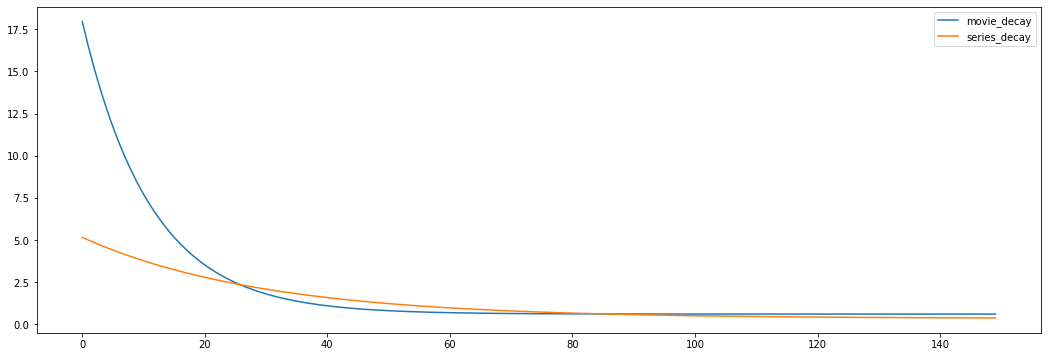

In [26]:
fig, ax = plt.subplots(figsize=(18, 6))
plt.plot(x, y1, label = 'movie_decay')
plt.plot(x, y2, label = 'series_decay')

plt.legend()
plt.show()

In [27]:
dt_df_movie = pd.DataFrame({'days_on_hbo_max': x,
                           'factor': y1,
                           'content_category': 'movies'})
dt_df_series = pd.DataFrame({'days_on_hbo_max': x,
                           'factor': y2,
                           'content_category': 'series'})
dt_df = pd.concat([dt_df_movie, dt_df_series], axis = 0)
dt_df.rename(columns = {'content_category':'category'}, inplace = True)

In [28]:
day_60_cum_sum = dt_df[dt_df['days_on_hbo_max']<60].groupby(['category']).factor.sum().reset_index()

In [29]:
hours_viewed_decay_norm = hours_viewed_thresh[hours_viewed_thresh['title_id'].isin(norm_title_id)].copy()

hours_viewed_decay_norm = hours_viewed_decay_norm.merge(dt_df, on = ['category'])\
                                                 .merge(day_60_cum_sum.rename(columns = {'factor':'cum_sum'}), on = ['category'])

hours_viewed_decay_norm['change_in_churn'] = hours_viewed_decay_norm['change_in_churn_60d']/hours_viewed_decay_norm['cum_sum']*hours_viewed_decay_norm['factor']*hours_viewed_decay_norm['asset_run_time_hours']

hours_viewed_decay_norm['request_date'] = pd.to_datetime(hours_viewed_decay_norm['offering_start_date']) \
                                        + pd.to_timedelta(hours_viewed_decay_norm['days_on_hbo_max'], unit='D')

hours_viewed_decay_norm = hours_viewed_decay_norm[hours_viewed_decay_norm['request_date'] <= '2023-03-01']

In [30]:
# hours_viewed_decay_norm[(hours_viewed_decay_norm['request_date'] >= '2022-12-01')
#                        &(hours_viewed_decay_norm['request_date'] <= '2022-12-31')]\
# .groupby(['title_name', 'season_number'])['change_in_churn'].sum().reset_index()\
# .sort_values(by = ['change_in_churn']).head(10)

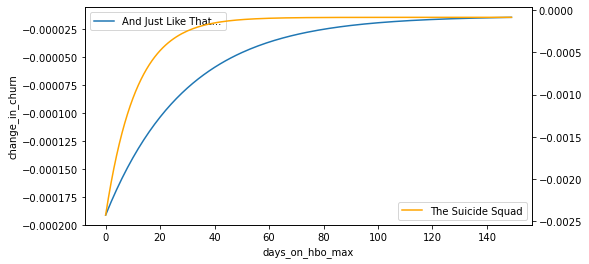

In [31]:
fig, ax = plt.subplots(figsize=(8, 4))
test = hours_viewed_decay_norm[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max','change_in_churn']]
plot_df = test[test['title_name'] == 'And Just Like That...']
ax.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn'], label='And Just Like That...')

ax2 = ax.twinx()
plot_df = test[test['title_name'] == 'The Suicide Squad']
ax2.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn'], label='The Suicide Squad', color = 'orange')

ax.set_xlabel('days_on_hbo_max')
ax.set_ylabel('change_in_churn')
ax.legend()
ax2.legend()

plt.show()

### 2. Evergreen Titles

#### 2.1 Sogmoid Decay

In [32]:
# ## 90% of the retention value is deteriorated in the first year
# x = [0, 0.25, 1.5, 3]
# y = [1, 0.99, 0.5, 0.001]

# def sigmoid(x, L ,x0, k, b):
#     y = L / (1 + np.exp(-k*(x-x0))) + b
#     return (y)

# p0 = [max(y), np.median(x),1,min(y)] # this is an mandatory initial guess

# popt, pcov = curve_fit(sigmoid, x, y ,p0, method='dogbox')

# x1 = pd.Series(np.arange(0,5,0.1))
# y1 = sigmoid(x1, *popt)

# fig, ax = plt.subplots(figsize=(18, 6))
# plt.plot(x1, y1)
# plt.show()

In [33]:
# dt_df = pd.DataFrame()
# dt_df['days_on_hbo_max'] = [i for i in range(0, 365*3, 1)]
# dt_df['factor'] = sigmoid(dt_df['days_on_hbo_max']/365, *popt)
# dt_df['key'] = 1

# hours_viewed_decay_evergreen = hours_viewed_thresh[hours_viewed_thresh['title_id'].isin(ever_green_title_id)]

# hours_viewed_decay_evergreen = hours_viewed_decay_evergreen.merge(dt_df, on = ['key']).drop(['key'], axis = 1)

# hours_viewed_decay_evergreen['change_in_churn'] = hours_viewed_decay_evergreen['change_in_churn_60d']/60*hours_viewed_decay_evergreen['factor']

# hours_viewed_decay_evergreen['days_on_hbo_max'] = hours_viewed_decay_evergreen['days_on_hbo_max']+60

# hours_viewed_decay_evergreen['request_date'] = pd.to_datetime(hours_viewed_decay_evergreen['offering_start_date']) \
#                                         + pd.to_timedelta(hours_viewed_decay_evergreen['days_on_hbo_max'], unit='D')

# hours_viewed_decay_evergreen = hours_viewed_decay_evergreen[hours_viewed_decay_evergreen['request_date'] <= '2023-03-01']


In [34]:
# fig, ax = plt.subplots(figsize=(8, 4))
# test = pd.concat([hours_viewed_60d[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']],
#                 hours_viewed_decay_evergreen[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']]],
#                 axis = 0)


# for i in range(1, 11, 1):
#     plot_df = test[(test['title_name'] == 'Friends') &(test['season_number'] == i)]
#     plt.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn'], label= 'Friends S' + str(i))

# ax.set_xlabel('days_on_hbo_max')
# ax.set_ylabel('change_in_churn')
# ax.legend()

# plt.show()

#### 2.2 Keep the retention value all the way along

In [35]:
dt_df = pd.DataFrame()
dt_df['days_on_hbo_max'] = [i for i in range(0, 365*3, 1)]
dt_df['key'] = 1

hours_viewed_decay_evergreen = hours_viewed_thresh[hours_viewed_thresh['title_id'].isin(ever_green_title_id)]
hours_viewed_decay_evergreen['key'] = 1

hours_viewed_decay_evergreen = hours_viewed_decay_evergreen.merge(dt_df, on = ['key']).drop(['key'], axis = 1)

hours_viewed_decay_evergreen['change_in_churn'] = hours_viewed_decay_evergreen['change_in_churn_60d']/60*hours_viewed_decay_evergreen['asset_run_time_hours']

hours_viewed_decay_evergreen['request_date'] = pd.to_datetime(hours_viewed_decay_evergreen['offering_start_date']) \
                                        + pd.to_timedelta(hours_viewed_decay_evergreen['days_on_hbo_max'], unit='D')

hours_viewed_decay_evergreen = hours_viewed_decay_evergreen[hours_viewed_decay_evergreen['request_date'] <= '2023-03-01']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


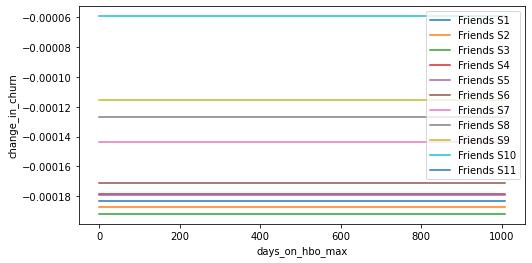

In [36]:
fig, ax = plt.subplots(figsize=(8, 4))
test = hours_viewed_decay_evergreen[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']]


for i in range(1, 12, 1):
    plot_df = test[(test['title_name'] == 'Friends') &(test['season_number'] == i)]
    plt.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn'], label= 'Friends S' + str(i))

ax.set_xlabel('days_on_hbo_max')
ax.set_ylabel('change_in_churn')
ax.legend()

plt.show()

## UNION ALL THE DFs

In [37]:
data = pd.concat([hours_viewed_decay_norm[['title_name', 'title_id', 'season_number', 'genre', 'medal', 'offering_start_date', 'request_date',  'days_on_hbo_max', 'change_in_churn']],
                hours_viewed_decay_evergreen[['title_name', 'title_id', 'season_number', 'genre', 'medal', 'offering_start_date', 'request_date',  'days_on_hbo_max', 'change_in_churn']] ],
                axis = 0)

In [38]:
data = data.merge(hours_viewed_thresh[['title_id', 'season_number', 'average_hours_viewed_60d', 'churn_per_hr_person', 'change_in_churn_60d', 'asset_run_time_hours']],
                 on = ['title_id', 'season_number'])

In [39]:
data['date_month'] = data['request_date'].dt.to_period('M')

# Correlation with Change in Churn

## 1. Correlation with Churn itself

In [52]:
# churn_genpop = run_query('''
# with pvc as (
# select
#     wholesale_user_activation.user_id,
#     hbo_uuid,
#     affiliate_code
# from max_prod.bi_analytics.wholesale_user_activation
#     left join max_prod.bi_analytics.dimension_user
#         on wholesale_user_activation.user_id = dimension_user.user_id
#     left join max_prod.core.geo_map
#         on wholesale_user_activation.country_code = geo_map.country_iso_code
# where
#     wholesale_user_activation.country_code = 'US'
#     and geo_map.territory = 'HBO MAX DOMESTIC'
#     and geo_map.region = 'NORTH AMERICA'
#     and affiliate_code = 'amazon_hbonow'
#     and convert_timezone('UTC', 'America/Los_Angeles', wholesale_user_activation.first_auth_time_utc::timestamp) >= '2020-11-17'
# )
# select
# date(date_trunc('Month', c.cycle_expire_date)) as date_month
# , c.is_cancel
#   ,count(distinct a.provider_user_id) as subscriber_count
# from max_dev.workspace.user_retain_churn_list_test c
# left join  max_prod.bi_analytics.fact_common_receipt a
#     on c.hurley_user_id=a.hurley_user_id
#     and a.subscription_start_date = c.cycle_start_date
# left join pvc 
#     on pvc.hbo_uuid = c.hbo_uuid
# where 1=1
# and cast(cycle_start_date as date) <'2023-05-01'
# and cast(cycle_expire_date as date) >='2022-01-01'
# and (a.signup_offer is NULL or a.signup_offer='no_free_trial')
# and affiliate_code is NULL
# and sub_month <= 24
# group by date_month, c.is_cancel
# ''')

In [59]:
# churn_genpop_tenure = run_query('''
# with pvc as (
# select
#     wholesale_user_activation.user_id,
#     hbo_uuid,
#     affiliate_code
# from max_prod.bi_analytics.wholesale_user_activation
#     left join max_prod.bi_analytics.dimension_user
#         on wholesale_user_activation.user_id = dimension_user.user_id
#     left join max_prod.core.geo_map
#         on wholesale_user_activation.country_code = geo_map.country_iso_code
# where
#     wholesale_user_activation.country_code = 'US'
#     and geo_map.territory = 'HBO MAX DOMESTIC'
#     and geo_map.region = 'NORTH AMERICA'
#     and affiliate_code = 'amazon_hbonow'
#     and convert_timezone('UTC', 'America/Los_Angeles', wholesale_user_activation.first_auth_time_utc::timestamp) >= '2020-11-17'
# )
# select
# date(date_trunc('Month', c.cycle_expire_date)) as date_month
# , sub_month
# , c.is_cancel
#   ,count(distinct a.provider_user_id) as subscriber_count
# from max_dev.workspace.user_retain_churn_list_test c
# left join  max_prod.bi_analytics.fact_common_receipt a
#     on c.hurley_user_id=a.hurley_user_id
#     and a.subscription_start_date = c.cycle_start_date
# left join pvc 
#     on pvc.hbo_uuid = c.hbo_uuid
# where 1=1
# and cast(cycle_start_date as date) <'2023-05-01'
# and cast(cycle_expire_date as date) >='2022-01-01'
# and (a.signup_offer is NULL or a.signup_offer='no_free_trial')
# and affiliate_code is NULL
# and sub_month <= 24
# group by date_month, sub_month, c.is_cancel
# order by sub_month DESC  
# ''')

In [53]:
# churn_exclude_t1 = run_query('''
# with pvc as (
# select
#     wholesale_user_activation.user_id,
#     hbo_uuid,
#     affiliate_code
# from max_prod.bi_analytics.wholesale_user_activation
#     left join max_prod.bi_analytics.dimension_user
#         on wholesale_user_activation.user_id = dimension_user.user_id
#     left join max_prod.core.geo_map
#         on wholesale_user_activation.country_code = geo_map.country_iso_code
# where
#     wholesale_user_activation.country_code = 'US'
#     and geo_map.territory = 'HBO MAX DOMESTIC'
#     and geo_map.region = 'NORTH AMERICA'
#     and affiliate_code = 'amazon_hbonow'
#     and convert_timezone('UTC', 'America/Los_Angeles', wholesale_user_activation.first_auth_time_utc::timestamp) >= '2020-11-17'
# )
# select
# date(date_trunc('Month', c.cycle_expire_date)) as date_month
# , c.is_cancel
#   ,count(distinct a.provider_user_id) as subscriber_count
# from max_dev.workspace.user_retain_churn_list_test c
# left join  max_prod.bi_analytics.fact_common_receipt a
#     on c.hurley_user_id=a.hurley_user_id
#     and a.subscription_start_date = c.cycle_start_date
# left join pvc 
#     on pvc.hbo_uuid = c.hbo_uuid
# where 1=1
# and cast(cycle_start_date as date) <'2023-05-01'
# and cast(cycle_expire_date as date) >='2022-01-01'
# and (a.signup_offer is NULL or a.signup_offer='no_free_trial')
# and affiliate_code is NULL
# and sub_month>1
# group by date_month, c.is_cancel
# ''')

In [60]:
# write_to_input(churn_genpop, 'churn_genpop')
# write_to_input(churn_genpop_tenure, 'churn_genpop_tenure')
# write_to_input(churn_exclude_t1, 'churn_exclude_t1')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [42]:
churn_genpop = read_from_s3('title_hours_viewed_retention/churn_genpop.csv')
churn_genpop_tenure = read_from_s3('title_hours_viewed_retention/churn_genpop_tenure.csv')
churn_exclude_t1 = read_from_s3('title_hours_viewed_retention/churn_exclude_t1.csv')

Reading title_hours_viewed_retention/churn_genpop.csv features
Reading title_hours_viewed_retention/churn_genpop_tenure.csv features
Reading title_hours_viewed_retention/churn_exclude_t1.csv features


In [43]:
churn_genpop['total_subscriber'] = churn_genpop.groupby(['date_month'])['subscriber_count'].transform('sum')
churn_genpop['churn_rate'] = churn_genpop['subscriber_count']/churn_genpop['total_subscriber']
churn_genpop = churn_genpop[churn_genpop['is_cancel'] == True]

churn_genpop_tenure['total_subscriber'] = churn_genpop_tenure.groupby(['date_month', 'sub_month'])['subscriber_count'].transform('sum')
churn_genpop_tenure['churn_rate'] = churn_genpop_tenure['subscriber_count']/churn_genpop_tenure['total_subscriber']
churn_genpop_tenure = churn_genpop_tenure[churn_genpop_tenure['is_cancel'] == True]

churn_exclude_t1['total_subscriber'] = churn_exclude_t1.groupby(['date_month'])['subscriber_count'].transform('sum')
churn_exclude_t1['churn_rate'] = churn_exclude_t1['subscriber_count']/churn_exclude_t1['total_subscriber']
churn_exclude_t1 = churn_exclude_t1[churn_exclude_t1['is_cancel'] == True]

In [44]:
aggregated_churn = data.groupby(['date_month'])['change_in_churn'].sum().reset_index()
aggregated_churn['date_month'] = aggregated_churn['date_month'].dt.to_timestamp().dt.strftime('%Y-%m-%d')

#### GENPOP ONLY LOOKS AT 2022-01-01 ON-WARDS ###################################
aggregated_churn = aggregated_churn[(aggregated_churn['date_month']>='2022-01-01')
                                   &(aggregated_churn['date_month']<='2023-02-01')
                                   ]

In [45]:
churn_genpop_tenure_pivot = pd.pivot_table(churn_genpop_tenure, values='churn_rate', index=['date_month'],
                       columns=['sub_month'], fill_value=0, aggfunc='first').reset_index()

In [46]:
churn_all = churn_genpop_tenure_pivot.merge(churn_genpop[['date_month', 'churn_rate']].rename(columns = {'churn_rate':'genpop_churn'}),
                                           on = ['date_month'])\
                                    .merge(churn_exclude_t1[['date_month', 'churn_rate']].rename(columns = {'churn_rate':'churn_exclude_t1'}),
                                          on = ['date_month'])

In [47]:
churn_all['date_month'] = churn_all['date_month'].astype(str)

In [48]:
churn_all.head()

,date_month,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,genpop_churn,churn_exclude_t1
0,2022-01-01,0.248178,0.155623,0.121944,0.109274,0.095811,0.090610,0.065764,0.061678,0.065651,...,0.026609,0.022625,0.017091,0.017563,0.039216,0.000000,0.000000,0.105263,0.088450,0.065103
1,2022-02-01,0.220287,0.145717,0.113277,0.095207,0.087219,0.079466,0.076550,0.057955,0.055873,...,0.032054,0.027833,0.028498,0.025038,0.015653,0.064220,0.037500,0.041667,0.077640,0.065185
2,2022-03-01,0.246934,0.160222,0.118878,0.093951,0.081534,0.073291,0.068943,0.067792,0.049941,...,0.030673,0.026484,0.023890,0.020491,0.015798,0.018299,0.031915,0.012821,0.077198,0.061731
3,2022-04-01,0.249417,0.176824,0.129607,0.104879,0.086425,0.074453,0.071057,0.066796,0.064316,...,0.028576,0.030031,0.026565,0.023560,0.020790,0.015309,0.015662,0.048193,0.075261,0.063931
4,2022-05-01,0.248945,0.159699,0.131202,0.102014,0.085766,0.073494,0.065372,0.063088,0.059888,...,0.028315,0.026931,0.029020,0.025223,0.021892,0.018683,0.014673,0.015955,0.070928,0.057973


In [49]:
churn_all = churn_all.merge(aggregated_churn, on = ['date_month'])

In [50]:
TARGET_COL = ['change_in_churn']
FEATURE_COLS = [i for i in range(1, 25)]+['genpop_churn', 'churn_exclude_t1']

In [51]:
for i in FEATURE_COLS:
    churn_all[i] = churn_all[i].astype(float)

In [52]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [53]:
plot_data=churn_all[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
# corr.sort_values(by = TARGET_COL)
# 0.819
corr

,change_in_churn
1,-0.284900
2,-0.142251
3,0.157687
4,0.125337
5,0.197155
6,-0.036140
7,0.298066
8,0.311191
9,-0.074409
10,0.281209


<AxesSubplot:>

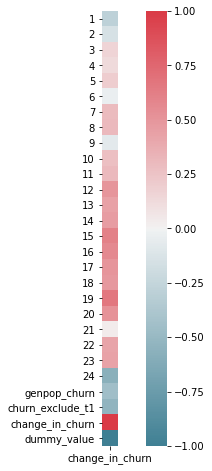

In [54]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [83]:
churn_month = ['retention','retention','retention',
               'retention','normal','normal',
               'churn','churn','normal',
               'churn','churn','normal',
              'retention','churn']

plot_df['retention_month'] = churn_month
plot_df_grp = plot_df.groupby(by=['retention_month']).mean().reset_index()
plot_df_grp.columns
plot_df_grp['average'] = plot_df_grp[['Month 3','Month 4-6', 'Month 7-12', 'Month 13+']].mean(axis=1)
plot_df_grp[['retention_month', 'Month 1',  'Month 2', 'Month 3',
       'Month 4-6', 'Month 7-12', 'Month 13+','average']]

,retention_month,Month 1,Month 2,Month 3,Month 4-6,Month 7-12,Month 13+,average
0,churn,0.235036,0.156385,0.132786,0.095926,0.062518,0.033335,0.081141
1,normal,0.229453,0.162842,0.129478,0.094181,0.058784,0.032222,0.078666
2,retention,0.245175,0.161648,0.124536,0.093504,0.058861,0.030563,0.076866


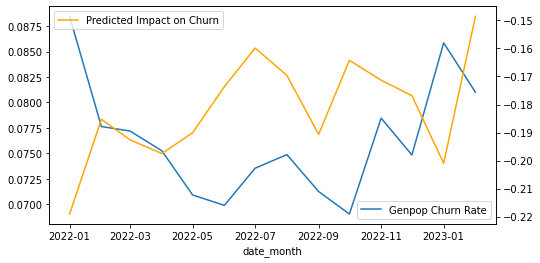

In [55]:
fig, ax = plt.subplots(figsize=(8, 4))

plot_df = churn_all
plot_df['date_month'] = pd.to_datetime(plot_df['date_month'])
ax.plot(plot_df['date_month'], plot_df['genpop_churn'], label= 'Genpop Churn Rate')

ax2 = ax.twinx()
ax2.plot(plot_df['date_month'], plot_df['change_in_churn'], label= 'Predicted Impact on Churn', color = 'orange')

ax.set_xlabel('date_month')
ax.legend(loc = 'lower right')
ax2.legend(loc = 'upper left')

plt.show()

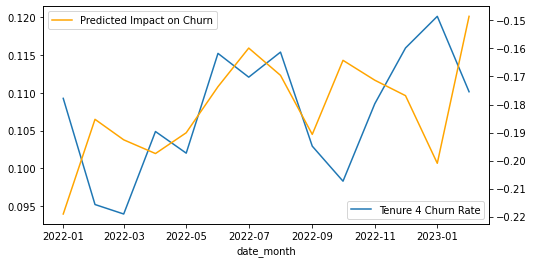

In [56]:
fig, ax = plt.subplots(figsize=(8, 4))

plot_df = churn_all
plot_df['date_month'] = pd.to_datetime(plot_df['date_month'])
ax.plot(plot_df['date_month'], plot_df[4], label= 'Tenure 4 Churn Rate')

ax2 = ax.twinx()
ax2.plot(plot_df['date_month'], plot_df['change_in_churn'], label= 'Predicted Impact on Churn', color = 'orange')

ax.set_xlabel('date_month')
ax.legend(loc = 'lower right')
ax2.legend(loc = 'upper left')

plt.show()

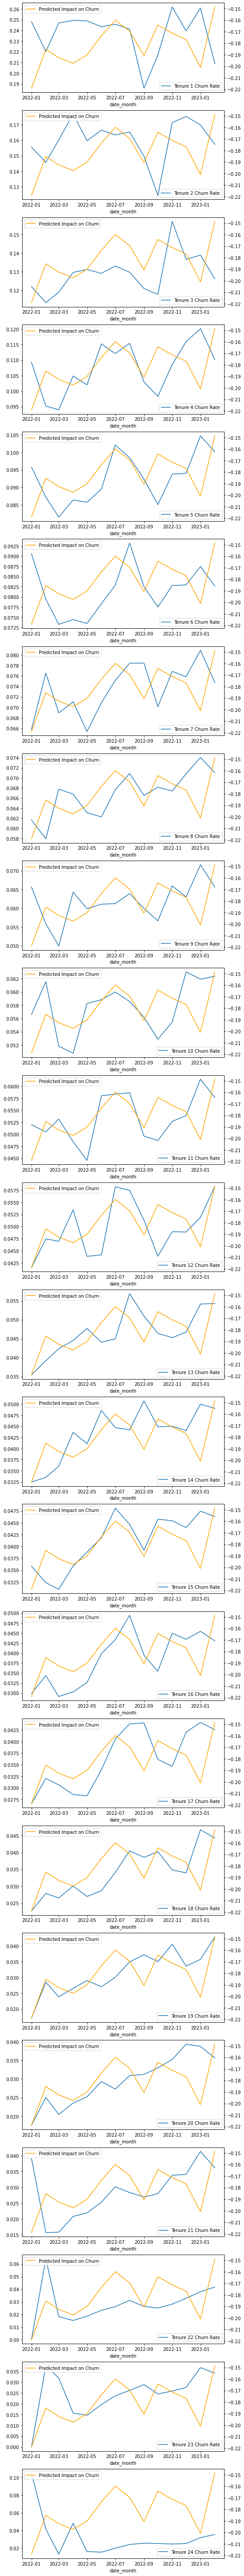

In [57]:
plot_df = churn_all
plot_df['date_month'] = pd.to_datetime(plot_df['date_month'])
fig, ax = plt.subplots(24,1,figsize=(8, 104))

for i in range(0, 24, 1):
    ax1 = ax[i]
    ax1.plot(plot_df['date_month'], plot_df[i+1], label= 'Tenure ' + str(i+1)+ ' Churn Rate')

    ax2 = ax[i].twinx()
    ax2.plot(plot_df['date_month'], plot_df['change_in_churn'], label= 'Predicted Impact on Churn', color = 'orange')

    ax1.set_xlabel('date_month')
    ax1.legend(loc = 'lower right')
    ax2.legend(loc = 'upper left')

plt.show()
    

## 2. Correlation with Tenure Buckets

In [77]:
# churn_genpop_tenure_bucekts = run_query('''
# with pvc as (
# select
#     wholesale_user_activation.user_id,
#     hbo_uuid,
#     affiliate_code
# from max_prod.bi_analytics.wholesale_user_activation
#     left join max_prod.bi_analytics.dimension_user
#         on wholesale_user_activation.user_id = dimension_user.user_id
#     left join max_prod.core.geo_map
#         on wholesale_user_activation.country_code = geo_map.country_iso_code
# where
#     wholesale_user_activation.country_code = 'US'
#     and geo_map.territory = 'HBO MAX DOMESTIC'
#     and geo_map.region = 'NORTH AMERICA'
#     and affiliate_code = 'amazon_hbonow'
#     and convert_timezone('UTC', 'America/Los_Angeles', wholesale_user_activation.first_auth_time_utc::timestamp) >= '2020-11-17'
# )
# select
# date(date_trunc('Month', c.cycle_expire_date)) as date_month
# , case when sub_month <=1 then 'Month 1'
#        when sub_month <=2 then 'Month 2'
#        when sub_month <=3 then 'Month 3'
#        when sub_month <=6 then 'Month 4-6'
#        when sub_month <=12 then 'Month 7-12'
#        else 'Month 13+'
#      end as tenure
# , c.is_cancel
#   ,count(distinct a.provider_user_id) as subscriber_count
# from max_dev.workspace.user_retain_churn_list_test c
# left join  max_prod.bi_analytics.fact_common_receipt a
#     on c.hurley_user_id=a.hurley_user_id
#     and a.subscription_start_date = c.cycle_start_date
# left join pvc 
#     on pvc.hbo_uuid = c.hbo_uuid
# where 1=1
# and cast(cycle_start_date as date) <'2023-05-01'
# and cast(cycle_expire_date as date) >='2022-01-01'
# and (a.signup_offer is NULL or a.signup_offer='no_free_trial')
# and affiliate_code is NULL
# --and sub_month <= 24
# group by date_month, tenure, c.is_cancel 
# ''')

In [80]:
# write_to_input(churn_genpop_tenure_bucekts, 'churn_genpop_tenure_bucekts')

In [6]:
churn_genpop_tenure_bucekts = read_from_s3('title_hours_viewed_retention/churn_genpop_tenure_bucekts.csv')

Reading title_hours_viewed_retention/churn_genpop_tenure_bucekts.csv features


In [7]:
churn_genpop_tenure_bucekts['total_subscriber'] = churn_genpop_tenure_bucekts.groupby(['date_month', 'tenure'])['subscriber_count'].transform('sum')
churn_genpop_tenure_bucekts['churn_rate'] = churn_genpop_tenure_bucekts['subscriber_count']/churn_genpop_tenure_bucekts['total_subscriber']
churn_genpop_tenure_bucekts = churn_genpop_tenure_bucekts[churn_genpop_tenure_bucekts['is_cancel'] == True]

In [8]:
churn_genpop_tenure_bucekts_pivot = pd.pivot_table(churn_genpop_tenure_bucekts, values='churn_rate', index=['date_month'],
                       columns=['tenure'], fill_value=0, aggfunc='first').reset_index()

In [40]:
aggregated_churn = data.groupby(['date_month'])['change_in_churn'].sum().reset_index()
aggregated_churn['date_month'] = aggregated_churn['date_month'].dt.to_timestamp().dt.strftime('%Y-%m-%d')

### GENPOP ONLY LOOKS AT 2022-01-01 ON-WARDS ###################################
aggregated_churn = aggregated_churn[(aggregated_churn['date_month']>='2022-01-01')
                                   &(aggregated_churn['date_month']<='2022-12-01')
                                   ]

In [58]:
churn_bucekts_all = churn_genpop_tenure_bucekts_pivot.merge(churn_genpop[['date_month', 'churn_rate']].rename(columns = {'churn_rate':'genpop_churn'}),
                                           on = ['date_month'])\
                                    .merge(churn_exclude_t1[['date_month', 'churn_rate']].rename(columns = {'churn_rate':'churn_exclude_t1'}),
                                          on = ['date_month'])

In [59]:
churn_bucekts_all['date_month'] = churn_bucekts_all['date_month'].astype(str)

In [60]:
churn_bucekts_all = churn_bucekts_all.merge(aggregated_churn, on = ['date_month'])

In [61]:
churn_bucekts_all.columns

Index(['date_month', 'Month 1', 'Month 13+', 'Month 2', 'Month 3', 'Month 4-6',
       'Month 7-12', 'genpop_churn', 'churn_exclude_t1', 'change_in_churn'],
      dtype='object')

In [62]:
TARGET_COL = ['change_in_churn']
FEATURE_COLS = ['Month 1','Month 2', 'Month 3', 'Month 4-6','Month 7-12', 'Month 13+','genpop_churn',]

In [63]:
for i in FEATURE_COLS:
    churn_bucekts_all[i] = churn_bucekts_all[i].astype(float)

In [64]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [65]:
plot_data=churn_bucekts_all[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
# corr.sort_values(by = TARGET_COL)
# 0.819
corr

,change_in_churn
Month 1,-0.284900
Month 2,-0.142251
Month 3,0.157687
Month 4-6,0.035229
Month 7-12,0.357085
Month 13+,0.512830
genpop_churn,-0.452277
change_in_churn,1.000000
dummy_value,-1.000000


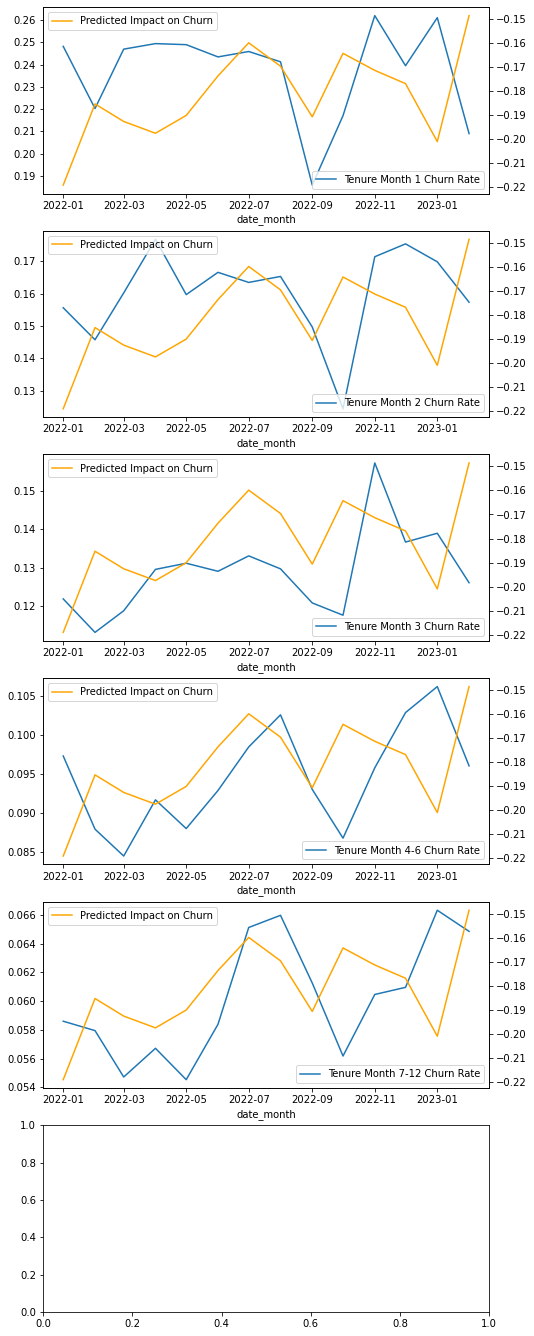

In [66]:
plot_df = churn_bucekts_all
plot_df['date_month'] = pd.to_datetime(plot_df['date_month'])
fig, ax = plt.subplots(6,1,figsize=(8, 24))

for i in range(0, 5, 1):
    ax1 = ax[i]
    month = FEATURE_COLS[i]
    ax1.plot(plot_df['date_month'], plot_df[month], label= 'Tenure ' + month+ ' Churn Rate')

    ax2 = ax[i].twinx()
    ax2.plot(plot_df['date_month'], plot_df['change_in_churn'], label= 'Predicted Impact on Churn', color = 'orange')

    ax1.set_xlabel('date_month')
    ax1.legend(loc = 'lower right')
    ax2.legend(loc = 'upper left')

plt.show()
    

<AxesSubplot:>

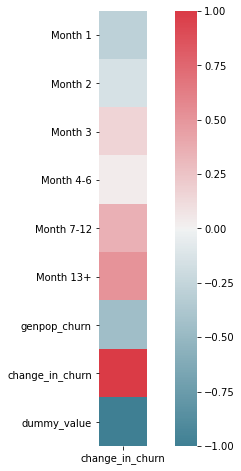

In [67]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [68]:
churn_bucekts_all.head()

,date_month,Month 1,Month 13+,Month 2,Month 3,Month 4-6,Month 7-12,genpop_churn,churn_exclude_t1,change_in_churn
0,2022-01-01,0.248178,0.027454,0.155623,0.121944,0.097306,0.058601,0.088450,0.065103,-0.219023
1,2022-02-01,0.220287,0.031318,0.145717,0.113277,0.087883,0.057947,0.077640,0.065185,-0.185275
2,2022-03-01,0.246934,0.028062,0.160222,0.118878,0.084423,0.054719,0.077198,0.061731,-0.192579
3,2022-04-01,0.249417,0.030444,0.176824,0.129607,0.091658,0.056716,0.075261,0.063931,-0.197475
4,2022-05-01,0.248945,0.031517,0.159699,0.131202,0.087960,0.054532,0.070928,0.057973,-0.190064


In [99]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [108]:
Re_Nom_Thresh = -0.17
Nom_Chu_Thresh= -0.19

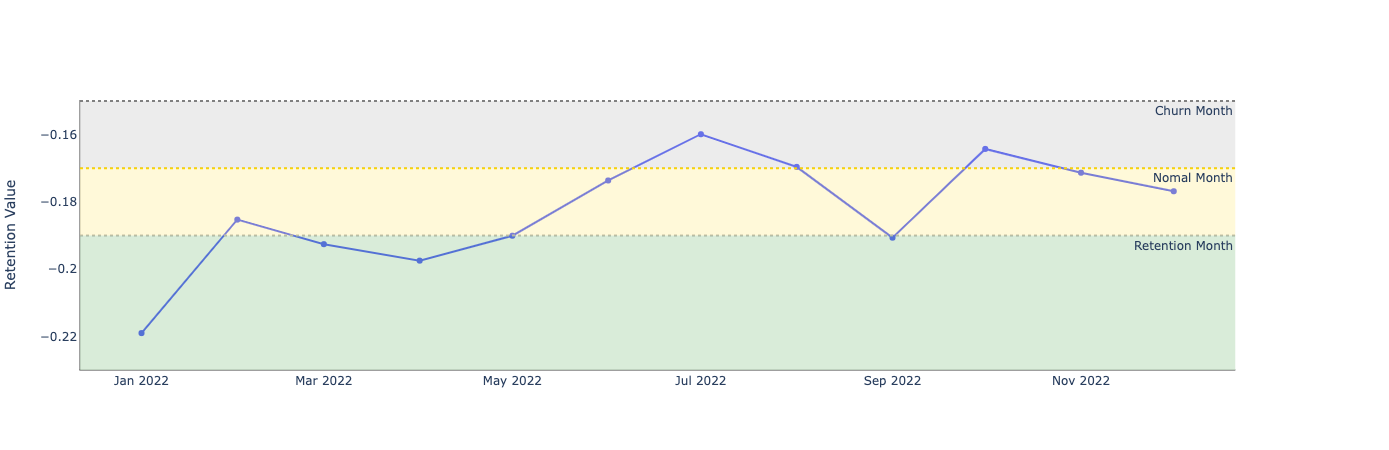

In [109]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=plot_df['date_month'], y=plot_df['change_in_churn'], name="Predicted Impact on Churn"),)

# fig.add_trace(
#     go.Scatter(x=plot_df['date_month'], y=plot_df['genpop_churn'], name="genpop_churn Churn rate"),secondary_y=True,)

fig.add_hline(y = Nom_Chu_Thresh, line_width=2, line_dash="dot", line_color="silver", annotation_text = 'Retention Month',
              annotation_position="bottom right")
fig.add_hline(y = Re_Nom_Thresh, line_width=2, line_dash="dot", line_color="gold", annotation_text = 'Nomal Month',
              annotation_position="bottom right")
fig.add_hline(y = -0.15, line_width=2, line_dash="dot", line_color="grey", annotation_text = 'Churn Month',
              annotation_position="bottom right")

fig.add_hrect(y0=-0.23, y1=Nom_Chu_Thresh, fillcolor="green", opacity=0.15, line_width=0)
fig.add_hrect(y0=Re_Nom_Thresh, y1=Nom_Chu_Thresh, fillcolor="gold", opacity=0.15, line_width=0)
fig.add_hrect(y0=Re_Nom_Thresh, y1=-0.15, fillcolor="grey", opacity=0.15, line_width=0)

# fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False, xaxis_zeroline=True, yaxis_zeroline=True,)
fig.update_layout(plot_bgcolor='rgb(255,255,255)')
fig.update_xaxes(showline=True, linewidth=0.5, linecolor='black')
fig.update_yaxes(showline=True, linewidth=0.5, linecolor='black')

fig.update_layout(legend=dict( orientation="h",
    yanchor="top",
    y=-0.1,
    xanchor="center",
    x=0.5
))

fig.update_yaxes(title_text="Historical Churn", secondary_y=True)
fig.update_yaxes(title_text="Retention Value", secondary_y=False)
fig.show()

In [110]:
churn_bucekts_all = churn_bucekts_all[FEATURE_COLS+['change_in_churn','date_month']]
churn_bucekts_all['month'] = 'Norm' 
churn_bucekts_all.loc[churn_bucekts_all['change_in_churn']<Nom_Chu_Thresh, 'month'] = 'Retention'
churn_bucekts_all.loc[churn_bucekts_all['change_in_churn']>Re_Nom_Thresh, 'month'] = 'Churn'

In [111]:
churn_bucekts_all.groupby(['month']).mean().reset_index()

,month,Month 1,Month 2,Month 3,Month 4-6,Month 7-12,Month 13+,genpop_churn,change_in_churn
0,Churn,0.234731,0.151053,0.126861,0.095937,0.062425,0.033582,0.072498,-0.164577
1,Norm,0.241301,0.164783,0.134071,0.094857,0.059439,0.031670,0.075215,-0.176771
2,Retention,0.235879,0.160408,0.124508,0.090870,0.057165,0.030157,0.076620,-0.197957


#### Write to S3/SF

In [337]:
filename = 'daily_monthly_retention_value_'+pd.Timestamp.today().strftime('%Y-%m-%d')
write_to_sf(data,  filename)

In [338]:
output_bucket+'/title_hours_viewed_retention/{}.csv'.format(filename)

'hbo-outbound-datascience-content-dev/title_hours_viewed_retention/daily_monthly_retention_value_2023-09-26.csv'